In [1]:
from __future__ import print_function

import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook
from ipywidgets import interact, FloatSlider
import numpy as np
import SimpleITK as sitk

# Download data to work on
%run update_path_to_download_script
from downloaddata import fetch_data as fdata
from myshow import myshow, myshow3d
# import itk
import gui
import os

In [2]:
import os
os.getcwd()

'C:\\Users\\Chia\\AppData\\Roaming\\SPB_16.6'

In [3]:
#image upload and rescaling

DIR="C:\\Users\\Chia\\Desktop\\Second Year\\YDB0001"
img = sitk.ReadImage("C://Users//Chia//Desktop//Second Year//HospitalProject//CTA_Head.nrrd")

img_255 = sitk.Cast(sitk.RescaleIntensity(img), sitk.sitkInt32)

myshow(img_255)

interactive(children=(IntSlider(value=75, description='z', max=150), Output()), _dom_classes=('widget-interact…

In [4]:
# Otsu thresholding filter -> binary image
FOV_mask = sitk.OtsuThreshold(img,0,1)
FOV_image = sitk.Mask(img,FOV_mask)
OTSU_mask = sitk.OtsuThreshold(FOV_image)
OTSU_image = sitk.Mask(img,OTSU_mask)
otsu_255 = sitk.Cast(sitk.RescaleIntensity(OTSU_image), sitk.sitkInt32)
myshow(OTSU_image)

# sitk.WriteImage(otsu_255, os.path.join(DIR, 'otzu.mhd'))
# myshow(otsu_255)

interactive(children=(IntSlider(value=75, description='z', max=150), Output()), _dom_classes=('widget-interact…

In [5]:
#segmentation
seed = (174,114,76)
seg_reg = sitk.Image(otsu_255.GetSize(), sitk.sitkInt32)
seg_reg.CopyInformation(otsu_255)
seg_reg[seed] = 1
seg_reg = sitk.BinaryDilate(seg_reg, 3)
myshow(sitk.LabelOverlay(otsu_255, seg_reg), "Initial Seed")

interactive(children=(IntSlider(value=75, description='z', max=150), Output()), _dom_classes=('widget-interact…

In [6]:
seg_reg = sitk.ConnectedThreshold(otsu_255, seedList=[seed], lower=0, upper=150)
myshow(sitk.LabelOverlay(otsu_255, seg_reg), "Connected Threshold")
print(seg_reg.GetSize())
sitk.WriteImage(seg_reg, os.path.join(DIR, 'segm.mhd'))

interactive(children=(IntSlider(value=75, description='z', max=150), Output()), _dom_classes=('widget-interact…

(340, 347, 151)


In [7]:
# Cropping segmentation
#best way to crop using ROI filter
filt=sitk.RegionOfInterestImageFilter()

filt.SetIndex([127,81,23])#,[84,208,14],[166,208,14],[84,121,36], [166,121,36],[84,208,36],[166,208,36])
filt.SetSize([221-127,156-81,101-23])
cr1=filt.Execute(seg_reg)

sitk.WriteImage(cr1, os.path.join(DIR, 'segmentation1.mhd'))

myshow(cr1)

interactive(children=(IntSlider(value=38, description='z', max=77), Output()), _dom_classes=('widget-interact'…

In [8]:
#center line with scimage
import skimage.morphology

nda = sitk.GetArrayFromImage(cr1)
# # print(nda)
axis=skimage.morphology.skeletonize_3d(nda)
axis = sitk.GetImageFromArray(axis)
sitk.WriteImage(axis, os.path.join(DIR, 'img_sciskeleton3D.mhd'))

myshow(axis, "middle line")
print(cr1.GetSize())
print(nda.shape)

interactive(children=(IntSlider(value=38, description='z', max=77), Output()), _dom_classes=('widget-interact'…

(94, 75, 78)
(78, 75, 94)


In [15]:
pasted_img=sitk.Image(cr1.GetSize(), sitk.sitkUInt8)

#medial axis in the horizontal plane
sk=np.zeros((221-127,156-81))
for x in range(0,78):
    sl=cr1[:,:,x]
    nda = sitk.GetArrayFromImage(sl)
# print(nda.size)
    skel=skimage.morphology.skeletonize(nda)
# print(skel.size)
    skel_int = skel.astype(np.uint8)
    skelindex=skel_int.nonzero()
    a=int(skelindex[0][:].size/2)
    x_skel=skelindex[0][a]
    y_skel=skelindex[1][a]
    sk[x_skel][y_skel]=1
    skel_img=sitk.GetImageFromArray(skel_int)
    
# print(skel_int.size)
    slice_vol = sitk.JoinSeries(skel_img)

# z insertion location

# paste the 3d white slice into the black volume
    pasted_img = sitk.Paste(pasted_img, slice_vol, slice_vol.GetSize(), destinationIndex=[0,0,x])
sitk.WriteImage(pasted_img, os.path.join(DIR, 'pasted_img.mhd'))
myshow(pasted_img)

interactive(children=(IntSlider(value=38, description='z', max=77), Output()), _dom_classes=('widget-interact'…

In [10]:
skel_img.GetPixelIDTypeAsString()
b=int(y_skel.astype('uint8'))
a=int(x_skel.astype('uint8'))
skel_img.SetPixel(a, b, 1)


In [68]:
import statistics
pasted_img=sitk.Image(cr1.GetSize(), sitk.sitkUInt8)
l=cr1.GetSize()
#medial axis in the horizontal plane
sk=np.zeros((221-127,156-81))
for x in range(0,78):
    sl=cr1[:,:,x]
    nda = sitk.GetArrayFromImage(sl)
    # print(nda.size)
    skel=skimage.morphology.skeletonize(nda)
    # print(skel.size)
    skel_int = skel.astype(np.uint8)
    skelindex=skel_int.nonzero()
    c=np.sort(skelindex)
    a=int(statistics.mean(c[0]))
    b=int(statistics.mean(c[1]))
#     x_skel=skelindex[0][a]
#     y_skel=skelindex[1][b]
    
    skel_img= sitk.Image(l[0], l[1], sitk.sitkUInt8)
#     b=int(y_skel.astype('uint8'))
#     a=int(x_skel.astype('uint8'))
    skel_img.SetPixel(a, b, 1)
    # print(skel_int.size)
    slice_vol = sitk.JoinSeries(skel_img)

    # z insertion location

    # paste the 3d white slice into the black volume
    pasted_img = sitk.Paste(pasted_img, slice_vol, slice_vol.GetSize(), destinationIndex=[0,0,x])
sitk.WriteImage(pasted_img, os.path.join(DIR, 'skelhor.mhd'))
myshow(pasted_img)

interactive(children=(IntSlider(value=38, description='z', max=77), Output()), _dom_classes=('widget-interact'…

In [69]:
import statistics

c=np.sort(skelindex)
statistics.median(c[0])
statistics.median(c[1])

46.5

In [70]:
from scipy.spatial import distance

size=cr1.GetSize()
nda = sitk.GetArrayFromImage(cr1)

pasted_arr=sitk.GetArrayFromImage(pasted_img)
s=size[2]
eu_s=[]
for z in range(0, size[2]):
    slicex=nda[:][:][z]
    sliceindex=slicex.nonzero()

    skelx=pasted_arr[:][:][z]
    skelindex=skelx.nonzero()
    eu_p=[]
    if skelindex[0][:].size == 1:
        for p in range(0,sliceindex[1][:].size):
            a=(sliceindex[0][p], sliceindex[1][p])
            b=(skelindex[0], skelindex[1])
            euclide=distance.euclidean(a, b)
            eu_p.append(euclide)
        eu=np.hstack(eu_p)
        e=max(eu)
        
    else: e=0
    eu_s.append(e)    
cross_sec=np.hstack(eu_s)

In [71]:
x=range(0, 78)
x=np.array(x)
print(x)
coss=np.array(cross_sec)
print(coss)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77]
[48.87739764 48.02082881 48.02082881 50.7740091  52.69724851 53.53503526
 53.         53.66563146 53.23532662 54.12947441 54.62600113 54.23098745
 55.15432893 55.15432893 54.62600113 54.23098745 52.92447449 51.623638
 51.88448708 49.76946855 50.56678752 49.04079934 48.70318265 49.76946855
 49.04079934 48.46648326 50.15974482 50.15974482 51.07837116 50.56678752
 51.4781507  50.69516742 50.56678752 48.46648326 45.88027899 46.06517123
 43.9089968  42.54409477 41.59326869 39.8246155  38.48376281 38.58756276
 38.07886553 37.21558813 37.58989226 37.58989226 36.24913792 36.24913792
 33.83784863 32.80243893 32.55764119 31.89043744 31.40063694 31.2409987
 31.144823   31.144823   32.01562119 34.82814953 35.4682957  35.80502758
 35.22782991 35.22782991 35.227829

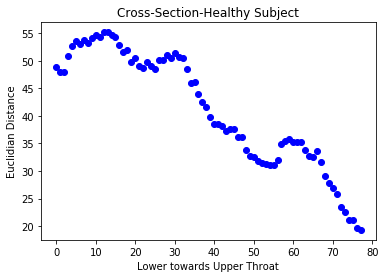

In [72]:
plt.plot(coss, 'bo')

plt.title('Cross-Section-Healthy Subject')
plt.ylabel('Euclidian Distance')
plt.xlabel('Lower towards Upper Throat')
plt.show()